In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-08-10 10:17:31.944397: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 10:17:31.960135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-10 10:17:31.984494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been register

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2025-08-10 10:17:34.209433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 10:17:34.260690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 10:17:34.264513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
data_labels = pd.read_csv('dev_data_2025.csv')
data_labels.head()
print(len(data_labels['imageID']))

5000


In [5]:
image_path = "Hematoxylin/"
images = os.listdir(image_path)
print(f"Total Number of Images:{len(images)}")

Total Number of Images:10298


In [6]:
images_set = set(images)
csv_images_set = set(data_labels['imageID'].astype(str))
print("Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))

#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: 5000


In [7]:
"""
I have two way of loading dataset, one is on the fly using tensorflow and another is this, this one is not memeory efficient enough but makes the training faster
I will do this for now, and later i will think about usinng tensorflow one the fly process. but lets create a pipline for now.
"""



# import os
# from PIL import Image

# # 1) Build a filename column that exactly matches what’s on disk
data_labels['filename'] = data_labels['imageID'].astype(str) + ".jpg"
data_labels['full_path'] = data_labels['filename'].apply(lambda x: os.path.join(image_path, x))

# # 2) Loader returns a dict keyed by *filename* (with extension)
# def load_images(image_folder, filenames):
#     images = {}
#     for fname in filenames:
#         img_path = os.path.join(image_folder, fname)
#         try:
#             with Image.open(img_path) as img:
#                 images[fname] = img.copy()
#         except Exception as e:
#             print(f"Error loading {fname}: {e}")
#     return images

# # 3) Load using the filename column, then map with the same key
# image_objects = load_images(image_path, data_labels['filename'])
# data_labels['Image'] = data_labels['filename'].map(image_objects)


In [8]:
print(data_labels.head())

     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole  \
0  Img_00001  Lymphocyte      round     unsegmented-round                no   
1  Img_00002    Monocyte  irregular  unsegmented-indented                no   
2  Img_00003    Monocyte  irregular             irregular               yes   
3  Img_00004    Basophil      round  segmented-multilobed                no   
4  Img_00005  Neutrophil      round      unsegmented-band                no   

        filename                  full_path  
0  Img_00001.jpg  Hematoxylin/Img_00001.jpg  
1  Img_00002.jpg  Hematoxylin/Img_00002.jpg  
2  Img_00003.jpg  Hematoxylin/Img_00003.jpg  
3  Img_00004.jpg  Hematoxylin/Img_00004.jpg  
4  Img_00005.jpg  Hematoxylin/Img_00005.jpg  


In [9]:
data_labels.iloc[900:]

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,filename,full_path
900,Img_00901,Lymphocyte,round,unsegmented-round,no,Img_00901.jpg,Hematoxylin/Img_00901.jpg
901,Img_00902,Neutrophil,round,unsegmented-band,no,Img_00902.jpg,Hematoxylin/Img_00902.jpg
902,Img_00903,Neutrophil,round,unsegmented-band,no,Img_00903.jpg,Hematoxylin/Img_00903.jpg
903,Img_00904,Eosinophil,round,segmented-bilobed,no,Img_00904.jpg,Hematoxylin/Img_00904.jpg
904,Img_00905,Monocyte,irregular,unsegmented-round,yes,Img_00905.jpg,Hematoxylin/Img_00905.jpg
...,...,...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no,Img_04996.jpg,Hematoxylin/Img_04996.jpg
4996,Img_04997,Neutrophil,round,unsegmented-band,no,Img_04997.jpg,Hematoxylin/Img_04997.jpg
4997,Img_04998,Basophil,round,irregular,no,Img_04998.jpg,Hematoxylin/Img_04998.jpg
4998,Img_04999,Neutrophil,round,unsegmented-band,no,Img_04999.jpg,Hematoxylin/Img_04999.jpg


In [10]:
data_labels.shape

(5000, 7)

In [11]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
 5   filename           5000 non-null   object
 6   full_path          5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


## EDA

In [12]:
print("Total samples:", len(data_labels))
print("\nMissing values:\n", data_labels.isnull().sum())
print("\nUnique labels per column:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {data_labels[col].unique()}")


Total samples: 5000

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
filename             0
full_path            0
dtype: int64

Unique labels per column:
label: ['Lymphocyte' 'Monocyte' 'Basophil' 'Neutrophil' 'Eosinophil']
cell_shape: ['round' 'irregular']
nucleus_shape: ['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']
cytoplasm_vacuole: ['no' 'yes']


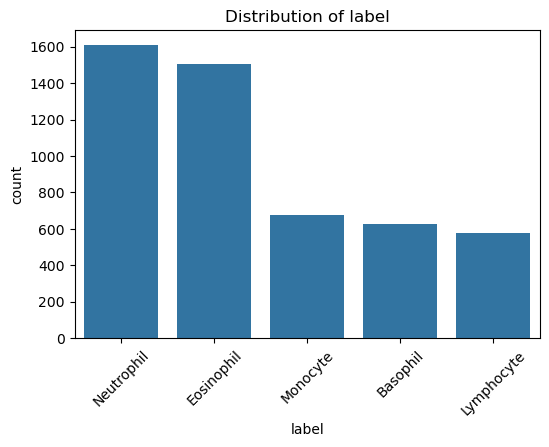

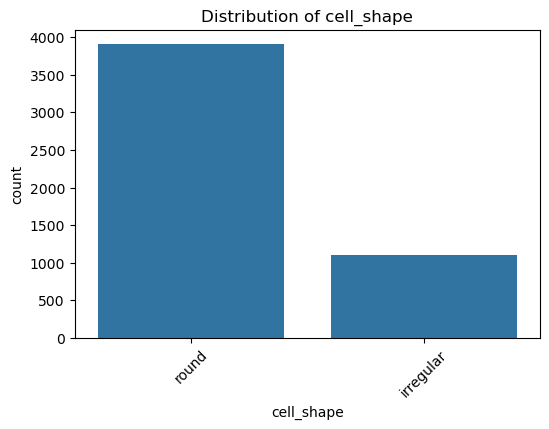

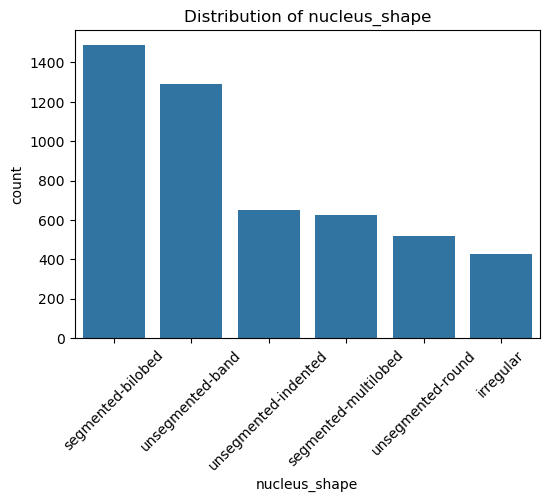

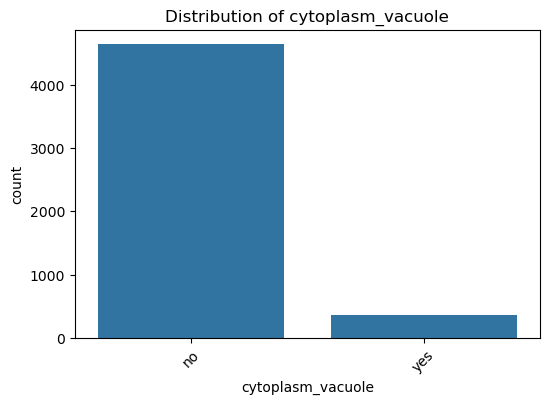

In [13]:
"""
class balance check, neutrophil and eosinophil has more distribution than other, have to take care of this.
round type shape is more
segmented and unsegmented is more
in cytoplasm vacuole, no has more data
"""

import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_labels, x=col, order=data_labels[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [14]:
# sizes = data_labels['Image'].apply(lambda img: img.size)
# print("Unique image shape and size:", sizes.value_counts())


from PIL import Image
from collections import Counter

size_counts = Counter()
for path in data_labels['full_path']:
    with Image.open(path) as img:
        size_counts[img.size] += 1

print("Unique image sizes and counts:", size_counts)


Unique image sizes and counts: Counter({(360, 363): 4875, (366, 369): 125})


In [15]:
import numpy as np
sample_path = data_labels['full_path'].iloc[0]
with Image.open(sample_path) as img:
    arr = np.array(img)
print("Pixel range:", arr.min(), "-", arr.max())
print("Shape:", arr.shape)


Pixel range: 24 - 255
Shape: (363, 360, 3)


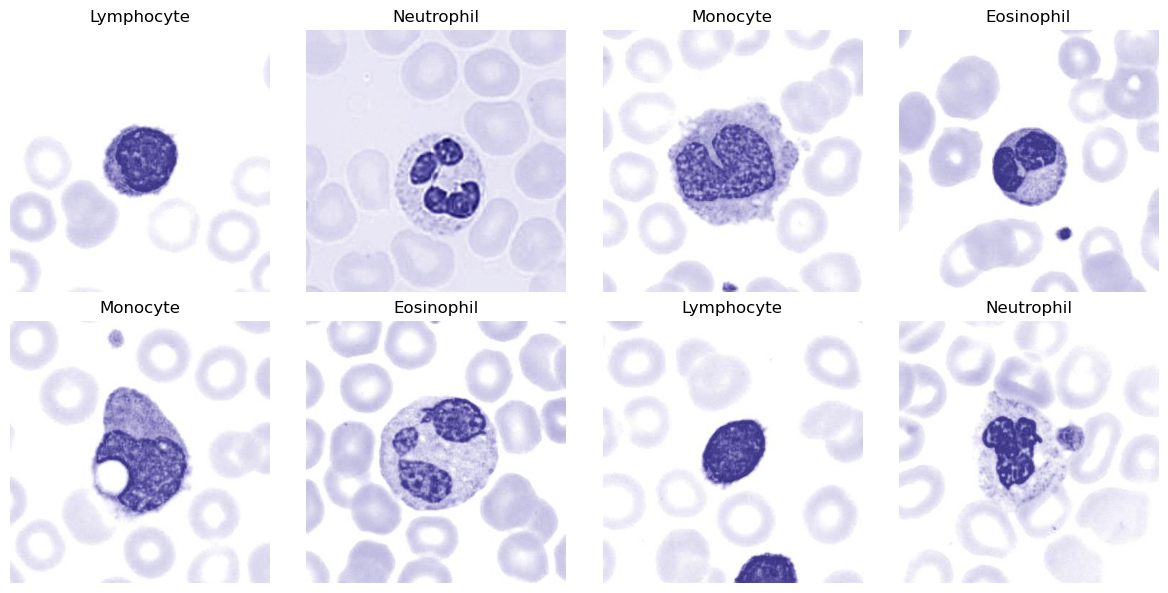

In [16]:
from random import sample

sample_paths = sample(list(data_labels['full_path']), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, path in zip(axes.flat, sample_paths):
    with Image.open(path) as img:
        ax.imshow(img)
    label = data_labels.loc[data_labels['full_path'] == path, 'label'].values[0]
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


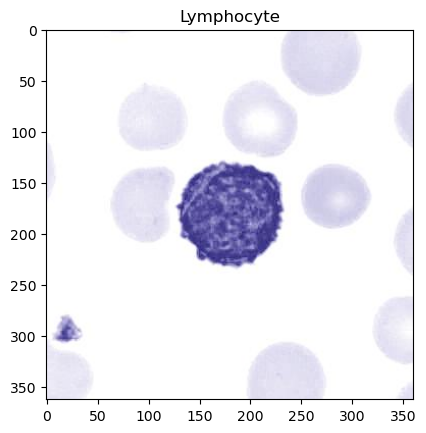

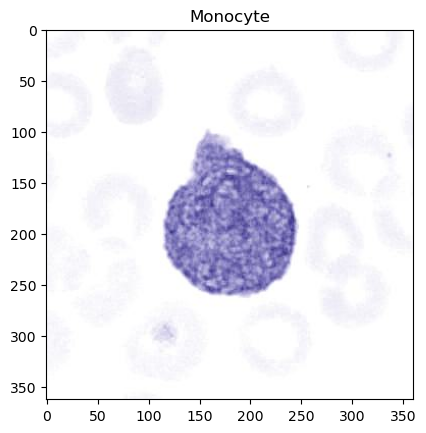

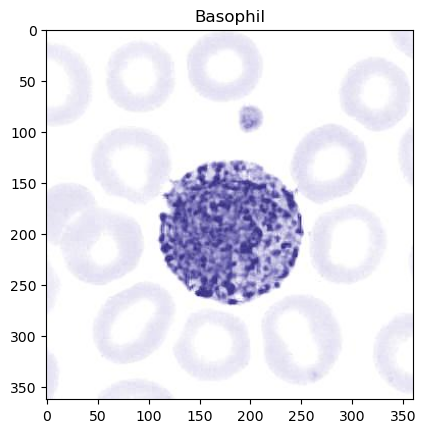

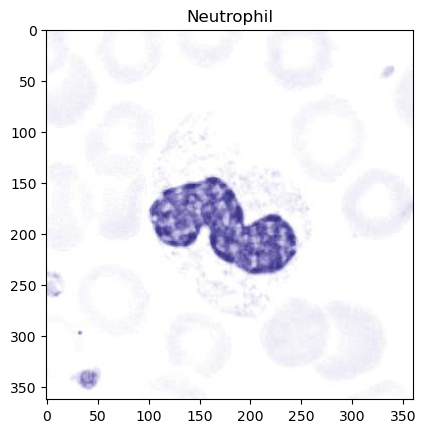

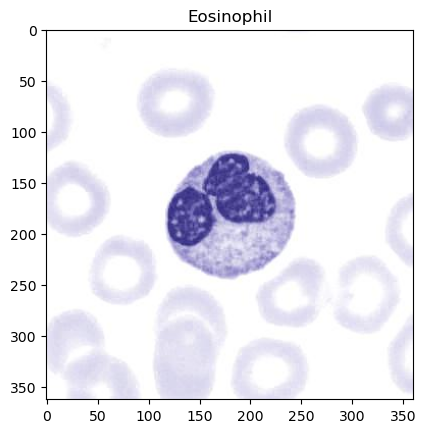

In [17]:
for cls in data_labels['label'].unique():
    sample_path = data_labels[data_labels['label'] == cls]['full_path'].sample(1).iloc[0]
    with Image.open(sample_path) as img:
        plt.imshow(img)
        plt.title(cls)
        plt.show()


In [19]:
# import numpy as np
# sample_img = np.array(data_labels['Image'].iloc[0])
# print("Pixel range:", sample_img.min(), "-", sample_img.max())
# print("Shape:", sample_img.shape)


In [21]:
# from random import sample

# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for ax, idx in zip(axes.flat, sample(range(len(data_labels)), 8)):
#     img = data_labels['Image'].iloc[idx]
#     label = data_labels['label'].iloc[idx]
#     ax.imshow(img)
#     ax.set_title(label)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()


## Data loading, Merging with images preparing for training

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf

TARGET_SIZE = (224, 224)  # good for transfer learning
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

# Use pandas' Categorical to encode string labels → ints (stable & simple)
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    data_labels[col] = pd.Categorical(data_labels[col])
    data_labels[col + '_idx'] = data_labels[col].cat.codes  # int labels starting at 0

# Keep mapping dicts for later decoding (nice for reports/confusion matrices)
idx2label = {i: c for i, c in enumerate(data_labels['label'].cat.categories)}
idx2cell  = {i: c for i, c in enumerate(data_labels['cell_shape'].cat.categories)}
idx2nuc   = {i: c for i, c in enumerate(data_labels['nucleus_shape'].cat.categories)}
idx2vac   = {i: c for i, c in enumerate(data_labels['cytoplasm_vacuole'].cat.categories)}

n_label = len(idx2label)
n_cell  = len(idx2cell)
n_nuc   = len(idx2nuc)
n_vac   = len(idx2vac)

print(n_label, n_cell, n_nuc, n_vac)


5 2 6 2


In [23]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data_labels,
    test_size=0.2,
    random_state=42,
    stratify=data_labels['label_idx']  # stratify on main class
)

len(train_df), len(val_df)


(4000, 1000)

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = 42
val_df = val_df.copy()  # just in case

# ---- 1) build a small EYEBALL set: per-class k samples ----
per_class = 10  # tweak: 8–12 is typical
eyeball_idx = []

for cls, group in val_df.groupby('label_idx'):
    take = group.sample(n=min(per_class, len(group)), random_state=rng).index
    eyeball_idx.append(take)

eyeball_idx = np.concatenate(eyeball_idx) if len(eyeball_idx) else np.array([], dtype=int)
eyeball_df  = val_df.loc[eyeball_idx].copy()

# remaining = blackbox candidate pool
blackbox_pool = val_df.drop(index=eyeball_idx)

# ---- 2) optionally keep blackbox to a fixed fraction of the whole val ----
# e.g., use all remaining (recommended) or take a fraction stratified
# here we keep ALL remaining:
blackbox_df = blackbox_pool.copy()

print({
    "eyeball_dev": len(eyeball_df),
    "blackbox_dev": len(blackbox_df)
})

# quick sanity
print("Eyeball per class:\n", eyeball_df['label'].value_counts())
print("Blackbox per class:\n", blackbox_df['label'].value_counts())


{'eyeball_dev': 50, 'blackbox_dev': 950}
Eyeball per class:
 label
Basophil      10
Eosinophil    10
Lymphocyte    10
Monocyte      10
Neutrophil    10
Name: count, dtype: int64
Blackbox per class:
 label
Neutrophil    312
Eosinophil    291
Monocyte      126
Basophil      115
Lymphocyte    106
Name: count, dtype: int64


In [25]:
def load_and_preprocess(path, y_label, y_cell, y_nuc, y_vac):
    # path: tf.string, labels: tf.int32
    img = tf.io.read_file(path)
    # use decode_jpeg or decode_image (handles png/jpg). You have .jpg, so:
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Optionally do light augmentation for training via a separate map
    labels = {
        'out_label': tf.one_hot(y_label, depth=n_label),
        'out_cell':  tf.one_hot(y_cell,  depth=n_cell),
        'out_nuc':   tf.one_hot(y_nuc,   depth=n_nuc),
        'out_vac':   tf.one_hot(y_vac,   depth=n_vac),
    }
    return img, labels

def make_dataset(df, shuffle=False, augment=False):
    paths = df['full_path'].astype(str).values
    y_label = df['label_idx'].values.astype(np.int32)
    y_cell  = df['cell_shape_idx'].values.astype(np.int32)
    y_nuc   = df['nucleus_shape_idx'].values.astype(np.int32)
    y_vac   = df['cytoplasm_vacuole_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_cell, y_nuc, y_vac))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=42)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        # light, morphology-safe augmentation (avoid extreme warps)
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
            tf.keras.layers.RandomBrightness(factor=0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds    = make_dataset(train_df, shuffle=True, augment=True)
eyeball_ds  = make_dataset(eyeball_df, shuffle=False, augment=False)
blackbox_ds = make_dataset(blackbox_df, shuffle=False, augment=False)


2025-08-10 10:22:53.211945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 10:22:53.217005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 10:22:53.220168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [26]:
xb, yb = next(iter(train_ds))
print("Batch images:", xb.shape)  # (B, 224, 224, 3)
for k, v in yb.items():
    print(k, v.shape)             # one-hot shapes per head


Batch images: (32, 224, 224, 3)
out_label (32, 5)
out_cell (32, 2)
out_nuc (32, 6)
out_vac (32, 2)


In [27]:
from tensorflow.keras import layers, models, applications

base = applications.EfficientNetB0(include_top=False, input_shape=(224,224,3), weights='imagenet')
base.trainable = False  # warm-up; later unfreeze some blocks

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)  # your identifiable, tunable block

# 4 heads
out_label = layers.Dense(n_label, activation='softmax', name='out_label')(x)
out_cell  = layers.Dense(n_cell,  activation='softmax', name='out_cell')(x)
out_nuc   = layers.Dense(n_nuc,   activation='softmax', name='out_nuc')(x)
out_vac   = layers.Dense(n_vac,   activation='softmax', name='out_vac')(x)

model = models.Model(inputs=base.input, outputs=[out_label, out_cell, out_nuc, out_vac])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        'out_label': 'categorical_crossentropy',
        'out_cell':  'categorical_crossentropy',
        'out_nuc':   'categorical_crossentropy',
        'out_vac':   'categorical_crossentropy',
    },
    loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
    metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [28]:
history = model.fit(
    train_ds,
    validation_data=blackbox_ds,
    epochs=10,
    # class_weight applies to ONE output; simplest is omit here for now,
    # or train main head separately if you must apply per-class weighting.
)


Epoch 1/10


2025-08-10 10:23:32.200514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-10 10:23:33.183418: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1754821414.206882    1817 service.cc:145] XLA service 0x7fbc4c322a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754821414.206927    1817 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-10 10:23:34.217717: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754821414.309474    1818 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

125/125 [==============================] - 80s 425ms/step - loss: 3.3185 - out_label_loss: 1.5400 - out_cell_loss: 0.5425 - out_nuc_loss: 1.7150 - out_vac_loss: 0.2831 - out_label_accuracy: 0.3162 - out_cell_accuracy: 0.7775 - out_nuc_accuracy: 0.2790 - out_vac_accuracy: 0.9235 - val_loss: 3.2176 - val_out_label_loss: 1.5033 - val_out_cell_loss: 0.5267 - val_out_nuc_loss: 1.6781 - val_out_vac_loss: 0.2441 - val_out_label_accuracy: 0.3284 - val_out_cell_accuracy: 0.7842 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/10
125/125 [==============================] - 46s 368ms/step - loss: 3.2763 - out_label_loss: 1.5233 - out_cell_loss: 0.5336 - out_nuc_loss: 1.7058 - out_vac_loss: 0.2650 - out_label_accuracy: 0.3257 - out_cell_accuracy: 0.7805 - out_nuc_accuracy: 0.2892 - out_vac_accuracy: 0.9273 - val_loss: 3.2423 - val_out_label_loss: 1.5193 - val_out_cell_loss: 0.5394 - val_out_nuc_loss: 1.6748 - val_out_vac_loss: 0.2472 - val_out_label_accuracy: 0.3063 - val_out_c